## The Particle Filter: A Simple Example



Let&rsquo;s check the bootstrap particle filter on a simple linear process:

\begin{eqnarray}
 \label{eq:state-transition}
 s_t &=& \rho s_{t-1} + \sigma_{e} \epsilon_t, \quad \epsilon_t\sim N(0,1) \\
 \label{eq:obs}
 y_t &=& 2 s_t + \sigma_u u_t, \quad u_t \sim N(0,1)
\end{eqnarray}

Let&rsquo;s set $\rho = 0.8$ and $\sigma_e = 0.1$.

Let&rsquo;s also assume that $s_0 \sim N(1,1)$.

We&rsquo;ll examine various choices of $\sigma_{u}$. 

We are going to go through one iteration of the particle filter,
with $M = 1000$ particles.  First, we load some libraries.  



In [1]:
%matplotlib inline 

import numpy as np
import pandas as p
import matplotlib.pyplot as plt
from scipy.stats import norm

Let&rsquo;s set up a particle approximation to the distribution
  $p(s_0)$, by drawing $M$ times from a Normal(1,1) distribution.



In [1]:
M = 1000
st_0 = norm.rvs(size=M, loc=1)
Wt_0 = np.ones((M))

How good is this approximation?  Let&rsquo;s check a histogram against
   the (known) true distribution.



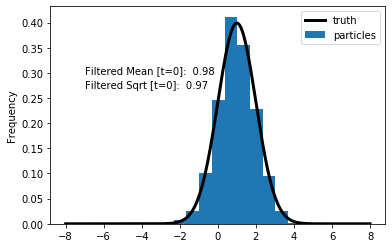

In [1]:
str1 = 'Filtered Mean [t=0]: %5.2f' % np.mean(st_0 * Wt_0)
str2 = 'Filtered Sqrt [t=0]: %5.2f' % np.sqrt(np.mean( ((st_0 * Wt_0) - np.mean(st_0 * Wt_0))**2 ))

ax=p.Series(st_0).plot(kind='hist',density=True)#, linewidth=3)
ax.annotate(str1, (-7,0.3))
ax.annotate(str2, (-7,0.27))
# the truth
grid = np.linspace(-8,8,1000)
ax.plot(grid, norm.pdf(grid,loc=1), linewidth=3, color='black')
ax.legend(['truth','particles']);

### Forecasting $s_1$



Next, we need to generate draws from $s_1|s_{0}^j$ for $j =
   1,\ldots,M$.  In the bootstrap particles, we simply use
   [eq:state-transition](#eq:state-transition) to do this.  Thus, for each of the $M = 1000$
   particles, we simulate from $s_1^j = \rho s_0^j+ \sigma_e e^j$
   with $e^j \sim N(0,1)$ for $j = 1,\ldots,M$.  

What does the resulting particle swarm look like?



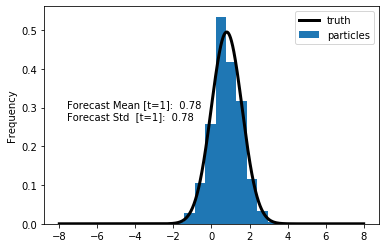

In [1]:
# bootstrap
rho, sigeps = 0.8, 0.1
st = rho * st_0 + sigeps * norm.rvs(size=M)

str1 = 'Forecast Mean [t=1]: %5.2f' % np.mean(st * Wt_0)
str2 = 'Forecast Std  [t=1]: %5.2f' % np.sqrt(np.mean( (st * Wt_0 - np.mean(st * Wt_0))**2 ))

ax=p.Series(st).plot(kind='hist', density=True)

ax.annotate(str1, (-7.6,0.3))
ax.annotate(str2, (-7.6,0.27))

true_loc = rho * 1 + sigeps * 0
true_sig = np.sqrt(rho**2 * 1 + sigeps**2 * 1)

ax.plot(grid, norm.pdf(grid,loc=true_loc, scale=true_sig), linewidth=3, color='black')
ax.legend(['truth', 'particles']);

### Updating $s_1|y_1$



Now it&rsquo;s time to reweight the particles based on the how well they
   actually predicted $y_1$.

To predict $y_1$, we simply multiply $s_t^i$ by 2. 

How good is this prediction, let&rsquo;s think about in the context of ME.

$y_1 = 0.2, \quad \sigma_u \in\{0.05, 0.3, 0.5\}$

If the ME is very small, the only particles that make very accurate
predictions are worthwhile.



### Predicting $y_1$



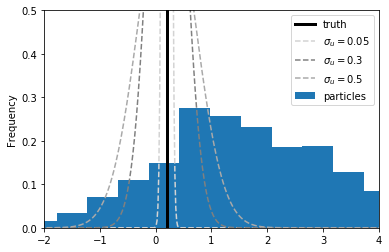

In [1]:
# yt = 2 * st + sigu * ut (ut ~ N(0,1))
sigu = 0.3
predyt = 2 * st 
ax = p.Series(predyt).plot(kind='hist',density=True,bins=20)

# the true yt
yt = 0.2
ax.axvline(yt, color='black',linewidth=3)

ax.plot(grid,norm.pdf(grid,loc=yt, scale=0.05), color='lightgrey',linestyle='dashed')
ax.plot(grid,norm.pdf(grid,loc=yt, scale=0.3), color='grey',linestyle='dashed')
ax.plot(grid,norm.pdf(grid,loc=yt, scale=0.5), color='darkgrey',linestyle='dashed')
ax.set_xlim(-2,4)
ax.set_ylim(0,.5)
ax.legend(['truth',r'$\sigma_u=0.05$',r'$\sigma_u=0.3$', r'$\sigma_u=0.5$','particles']);

### Updated $s_1, \sigma_u = 0.3$



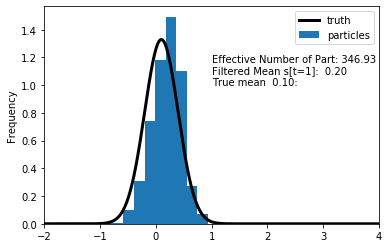

In [1]:
sigu = 0.3

wt_tilde = 1/ sigu * np.exp(-0.5 * (yt - 2*st)**2/sigu)

Wt = wt_tilde * Wt_0
Wt = Wt / np.mean(Wt)
str1 = 'Effective Number of Part: %5.2f' % (M/np.mean(Wt**2))
str2 = 'Filtered Mean s[t=1]: %5.2f' % np.mean(st * Wt)
str3 = 'True mean %5.2f:' % (yt/2)

# resampling 
inds = np.random.multinomial(M,Wt/M)
st_update = np.repeat(st,inds)

# plot density
ax = p.Series(st_update).plot(kind='hist', density=True)
ax.plot(grid, norm.pdf(grid, loc=yt/2, scale=sigu), color='black', linewidth=3)
ax.legend(['truth','particles'])
ax.set_xlim(-2,4)
ax.annotate('\n'.join([str1,str2,str3]), xy=(1,1.00));

### Updated $s_1, \sigma_u = 0.5$



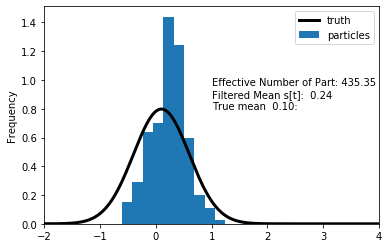

In [1]:
sigu = 0.5

wt_tilde = 1/ sigu * np.exp(-0.5 * (yt - 2*st)**2/sigu)

Wt = wt_tilde * Wt_0
Wt = Wt / np.mean(Wt)
str1 = 'Effective Number of Part: %5.2f' % (M/np.mean(Wt**2))
str2 = 'Filtered Mean s[t]: %5.2f' % np.mean(st * Wt)
str3 = 'True mean %5.2f:' % (yt/2)

# resampling 
inds = np.random.multinomial(M,Wt/M)
st_update = np.repeat(st,inds)

# plot density
ax = p.Series(st_update).plot(kind='hist', density=True)
ax.plot(grid, norm.pdf(grid, loc=yt/2, scale=sigu), color='black', linewidth=3)
ax.legend(['truth','particles'])
ax.set_xlim(-2,4)
ax.annotate('\n'.join([str1,str2,str3]), xy=(1,0.8));

### Updated $s_1, \sigma_u = 0.05$



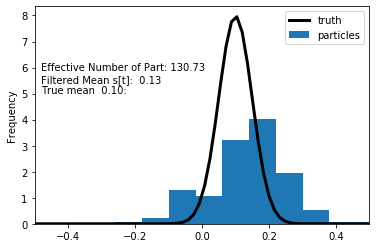

In [1]:
sigu = 0.05

wt_tilde = 1/ sigu * np.exp(-0.5 * (yt - 2*st)**2/sigu)

Wt = wt_tilde * Wt_0
Wt = Wt / np.mean(Wt)
str1 = 'Effective Number of Part: %5.2f' % (M/np.mean(Wt**2))
str2 = 'Filtered Mean s[t]: %5.2f' % np.mean(st * Wt)
str3 = 'True mean %5.2f:' % (yt/2)

# resampling 
inds = np.random.multinomial(M,Wt/M)
st_update = np.repeat(st,inds)

# plot density
ax = p.Series(st_update).plot(kind='hist', density=True)
ax.plot(grid, norm.pdf(grid, loc=yt/2, scale=sigu), color='black', linewidth=3)
ax.legend(['truth','particles'])
ax.set_xlim(-0.5,0.5)
ax.annotate('\n'.join([str1,str2,str3]), xy=(-0.48,5));